In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from google.colab.patches import cv2_imshow
from os import listdir
from os.path import isfile, join

from sklearn.model_selection import train_test_split

import tensorflow as tf

# Load Dataset

In [37]:
!git clone https://github.com/seensiravit/Parkinson-Early-Detection.git

fatal: destination path 'Parkinson-Early-Detection' already exists and is not an empty directory.


In [38]:
PD_data_path = '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral'
H_data_path = '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral'

In [39]:
H_img = [H_data_path+'/'+f for f in listdir(H_data_path)]
PD_img = [PD_data_path+'/'+f for f in listdir(PD_data_path)]

In [40]:
print(H_img[:5])
print(PD_img[:5])

['/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp4-H17.jpg', '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp1-H13.jpg', '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp2-H20.jpg', '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp4-H16.jpg', '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp2-H14.jpg']
['/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp4-H17.jpg', '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp1-H13.jpg', '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp2-H20.jpg', '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp4-H16.jpg', '/content/Parkinson-Early-Detection/dataset/HandPD/spiral/HealthySpiral/sp2-H14.jpg']


In [41]:
def display_image(path) :
  image = cv2.imread(path , 1)
  cv2_imshow(image)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

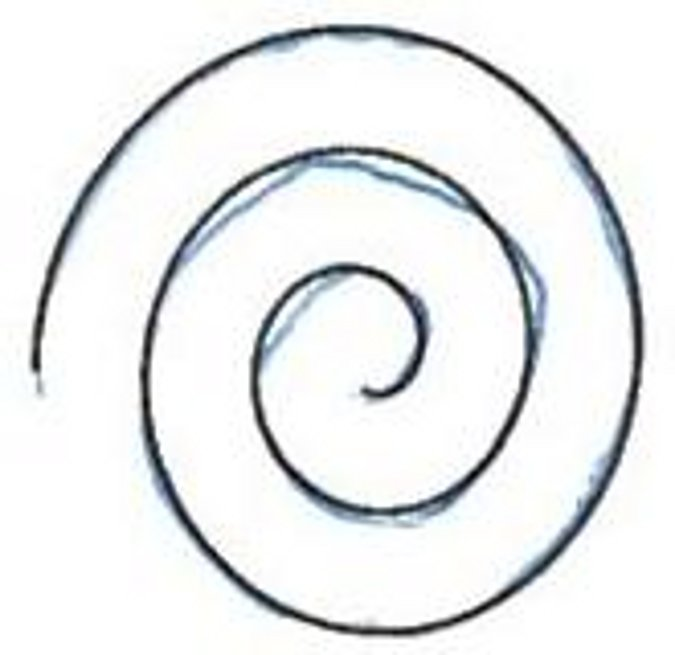

In [42]:
display_image(H_img[0])

# Create Dataframe (Image)

In [43]:
df_img = pd.concat([pd.DataFrame({'PNG':path , 'PD':0} for path in H_img) , pd.DataFrame({'PNG':path , 'PD':1} for path in PD_img)] , ignore_index=True)
df_img

,PNG,PD
0,/content/Parkinson-Early-Detection/dataset/Han...,0
1,/content/Parkinson-Early-Detection/dataset/Han...,0
2,/content/Parkinson-Early-Detection/dataset/Han...,0
3,/content/Parkinson-Early-Detection/dataset/Han...,0
4,/content/Parkinson-Early-Detection/dataset/Han...,0
...,...,...
275,/content/Parkinson-Early-Detection/dataset/Han...,1
276,/content/Parkinson-Early-Detection/dataset/Han...,1
277,/content/Parkinson-Early-Detection/dataset/Han...,1
278,/content/Parkinson-Early-Detection/dataset/Han...,1


In [44]:
df_img = df_img.sample(frac = 1)
df_img = df_img.reset_index()
df_img

,index,PNG,PD
0,109,/content/Parkinson-Early-Detection/dataset/Han...,0
1,238,/content/Parkinson-Early-Detection/dataset/Han...,1
2,141,/content/Parkinson-Early-Detection/dataset/Han...,1
3,6,/content/Parkinson-Early-Detection/dataset/Han...,0
4,98,/content/Parkinson-Early-Detection/dataset/Han...,0
...,...,...,...
275,228,/content/Parkinson-Early-Detection/dataset/Han...,1
276,126,/content/Parkinson-Early-Detection/dataset/Han...,0
277,195,/content/Parkinson-Early-Detection/dataset/Han...,1
278,150,/content/Parkinson-Early-Detection/dataset/Han...,1


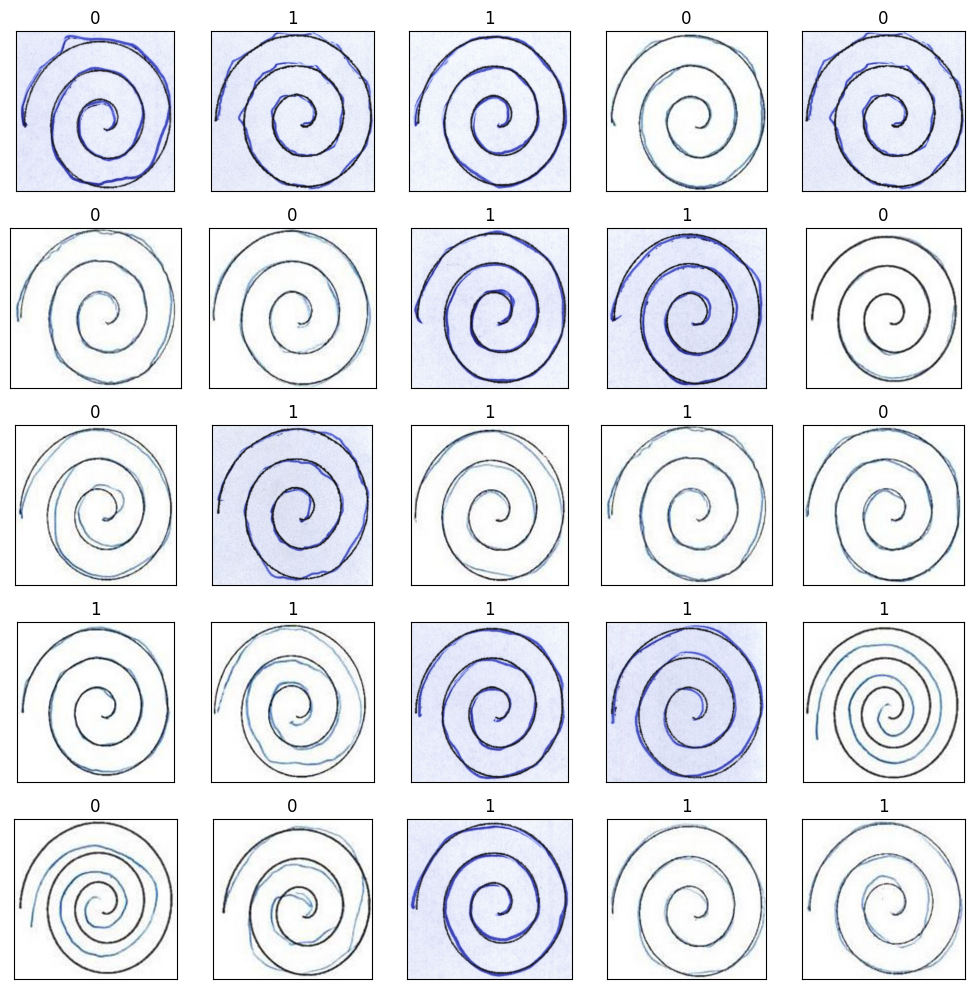

In [45]:
fig, axes = plt.subplots(nrows=5,
                        ncols=5,
                        figsize=(10,10),
                        subplot_kw={"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_img["PNG"][i]))
    ax.set_title(df_img["PD"][i])
plt.tight_layout()
plt.show()

# split data

In [46]:
tv_dir , test_dir = train_test_split(df_img , test_size=0.08 , random_state=1)

In [47]:
train_dir , valid_dir = train_test_split(tv_dir , test_size=0.06 , random_state=1)

In [48]:
print(f'train {train_dir.shape}')
print(f'valid {valid_dir.shape}')
print(f'test_dir {test_dir.shape}')

train (241, 3)
valid (16, 3)
test_dir (23, 3)


# Tranform data



In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [50]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )


In [51]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

TypeError: listdir: path should be string, bytes, os.PathLike, integer or None, not DataFrame

# VGG 16

source code : https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers

In [ ]:
base_model = VGG16(input_shape = (635,675,3), # Shape of our images
                    include_top = False, # Leave out the last fully connected layer
                    weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

# Train

In [ ]:
history  = model.fit(x_train , y_train , epochs=30 , validation_data=(x_valid , y_valid))